# RSS

In [31]:
import feedparser
from datetime import datetime

DATA_PATH='/home/bkadmin/datasets/spatialedge-hackathon-H1/v1/' 
FROM_DATE='20200101'
TO_DATE='20221231'
SYMBOL = 'EURUSD'
TIMEFRAME = 'H1'

### Pull feed from google News

In [92]:
# feed = feedparser.parse("https://news.google.com/rss/search?q=central+bank+US+EU+site%3Abloomberg.com+when%3A1d&hl=en-ZA&gl=ZA&ceid=ZA%3Aen")

# feed2 = feedparser.parse("https://news.google.com/rss/topics/CAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVAB/sections/CAQiSENCQVNNQW9JTDIwdk1EbHpNV1lTQW1WdUdnSlZVeUlQQ0FRYUN3b0pMMjB2TUdkbWNITXpLZ3NTQ1M5dEx6Qm5abkJ6TXlnQSoqCAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVABUAE?hl=en-US&gl=US&ceid=US%3Aen")

# feed3 = feedparser.parse("https://news.google.com/rss/search?q=EU+Europe+when%3A1y+-War+-Cut+-Cuts+-Low&hl=en-ZA&gl=ZA&ceid=ZA%3Aen")

feeds = ["https://news.google.com/rss/search?q=central+bank+US+EU+site%3Abloomberg.com+when%3A1d&hl=en-ZA&gl=ZA&ceid=ZA%3Aen",
         "https://news.google.com/rss/topics/CAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVAB/sections/CAQiSENCQVNNQW9JTDIwdk1EbHpNV1lTQW1WdUdnSlZVeUlQQ0FRYUN3b0pMMjB2TUdkbWNITXpLZ3NTQ1M5dEx6Qm5abkJ6TXlnQSoqCAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVABUAE?hl=en-US&gl=US&ceid=US%3Aen",
         "https://news.google.com/rss/search?q=US+EU+United+States+Europe++site%3Abloomberg.com+%22central+bank%22+when%3A1y&hl=en-ZA&gl=ZA&ceid=ZA%3Aen",
         "https://news.google.com/rss/search?q=US+EU+United+States+Europe+site%3Adailymaverick.co.za+%22central+bank%22+when%3A1y&hl=en-ZA&gl=ZA&ceid=ZA%3Aen",
         "https://news.google.com/rss/search?q=US+EU+United+States+Europe+site%3Areuters.com+%22central+bank%22+when%3A1y&hl=en-ZA&gl=ZA&ceid=ZA%3Aen"]

### Exstract Titles and publish dates

In [93]:
titles = []
dates = []

for feed in feeds:
    for post in feedparser.parse(feed).entries:
        title = post.title
        date = post.published
        titles.append(title.replace(' - Bloomberg', ''))
        dates.append(datetime.strptime(date, '%a, %d %b %Y %X %Z').date())

print('Number of RSS posts :', len(titles))

Number of RSS posts : 468


### Create Dataframe

In [94]:
import pandas as pd

df = pd.DataFrame({'Title': titles, 'Date': pd.to_datetime(dates)}) #df.info()
df

,Title,Date
0,"EU Migration: Macron, Scholz, Orban, Sunak Fig...",2023-10-06
1,Larry Summers Says Fed's Rate Hikes May Not Be...,2023-10-06
2,Treasuries Tumble as US Payroll Growth Blows P...,2023-10-06
3,BYD to Stick to Europe Growth Plans Despite Su...,2023-10-07
4,Turkey Vows to Build Reserves as IMF Sees Slow...,2023-10-07
...,...,...
463,Europe stocks dip as Italian banks hit by wind...,2023-08-08
464,ECB must not stop rate hikes before core infla...,2022-11-07
465,ECB warns of losses as it pays price for decad...,2022-11-29
466,"Yen slides, dollar gains as Bank of Japan is e...",2023-07-21


## Model

#### Import training dataset

In [35]:
DATASETS = '~/datasets/sentiment_economy_news/'

train = pd.read_parquet(DATASETS + 'train.parquet', engine='pyarrow')
test  = pd.read_parquet(DATASETS + 'test.parquet', engine='pyarrow')

print(train.tail())
print(train.info())

print(test.tail())
print(test.info())

#### Create a classifier model

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

X_train = train['text']
X_test = test['text']

Y_train = pd.Categorical(train['labels'])
Y_test = pd.Categorical(test['labels'])
labels = Y_train.categories

vectorizer = CountVectorizer()

X_train_tokens = vectorizer.fit_transform(train["text"])

transformer = TfidfTransformer()

X_train_tf = transformer.fit_transform(X_train_tokens)

#title_clf = GaussianNB().fit(X_train_tf.toarray(), Y_train)

#title_clf = Pipeline([
#    ('vect', CountVectorizer()),
#    ('tfidf', TfidfTransformer()),
#    ('clf', GaussianNB()),
#])

#### Train model

In [37]:
title_clf = GaussianNB().fit(X_train_tf.toarray(), Y_train)

#### Evaluate Model

In [38]:

from sklearn.metrics import classification_report

X_test_tokens = vectorizer.transform(test['text'])
X_test_tf = transformer.transform(X_test_tokens)

predicted = title_clf.predict(X_test_tf.toarray())

print(classification_report(Y_test, predicted, target_names=labels))

              precision    recall  f1-score   support

    negative       0.62      0.78      0.69       241
    positive       0.34      0.19      0.24       141

    accuracy                           0.56       382
   macro avg       0.48      0.49      0.47       382
weighted avg       0.52      0.56      0.53       382



#### Plot a bar chart on predicted labels for testing data

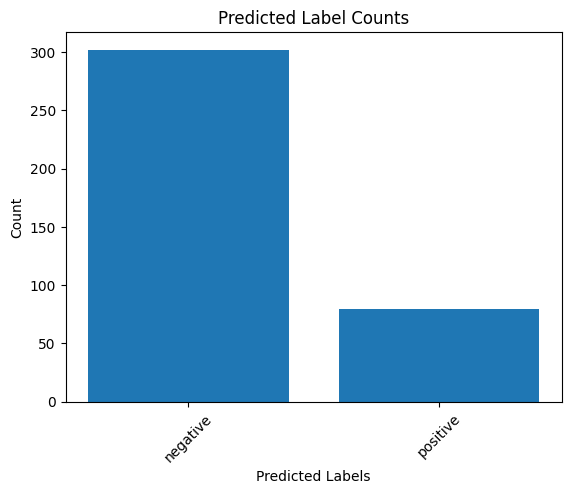

In [39]:
import matplotlib.pyplot as plt 
from collections import Counter

label_counts = Counter(predicted)

# Extract labels and counts as separate lists
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar chart
plt.bar(labels, counts)
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Predicted Label Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## Evaluate model on aggregated news sources

In [95]:
X_titles = df['Title']

X_titles_tokens = vectorizer.transform(X_titles)
X_titles_tf = transformer.transform(X_titles_tokens)

Y_predict = title_clf.predict(X_titles_tf.toarray())

df['labels'] = Y_predict

df

,Title,Date,labels
0,"EU Migration: Macron, Scholz, Orban, Sunak Fig...",2023-10-06,negative
1,Larry Summers Says Fed's Rate Hikes May Not Be...,2023-10-06,positive
2,Treasuries Tumble as US Payroll Growth Blows P...,2023-10-06,positive
3,BYD to Stick to Europe Growth Plans Despite Su...,2023-10-07,negative
4,Turkey Vows to Build Reserves as IMF Sees Slow...,2023-10-07,negative
...,...,...,...
463,Europe stocks dip as Italian banks hit by wind...,2023-08-08,negative
464,ECB must not stop rate hikes before core infla...,2022-11-07,positive
465,ECB warns of losses as it pays price for decad...,2022-11-29,negative
466,"Yen slides, dollar gains as Bank of Japan is e...",2023-07-21,positive


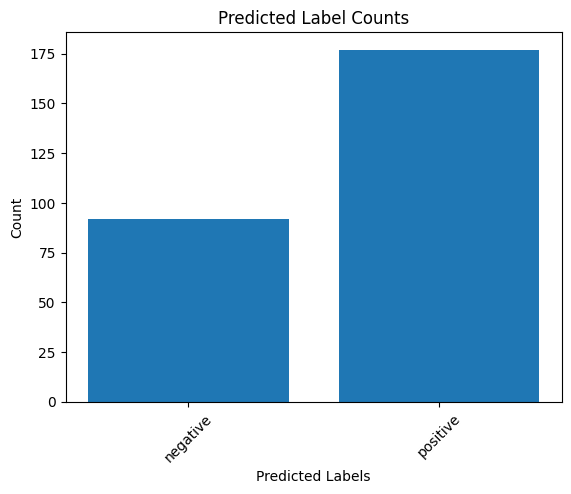

In [41]:
label_counts = Counter(Y_predict)

# Extract labels and counts as separate lists
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar chart
plt.bar(labels, counts)
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Predicted Label Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Search for some tags & Print final dataframe

In [97]:
if SYMBOL == 'EURUSD':
    search = ['US','U.S.', 'United States', 'North America', 'EU', 'Europe', 'Central Bank', 'Treasuries', 'Treasury', 'Inflation']
else:
    search = []

## Expand for other pairs

tags_in_title = []
for title in titles:
    tags = []
    for tag in search:
        if tag.lower() in title.lower(): tags+=[tag]
    tags_in_title += [tags]

df['Tags'] = tags_in_title

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
df

,Title,Date,labels,Tags
0,"EU Migration: Macron, Scholz, Orban, Sunak Fight at Summit in Spain",2023-10-06,negative,[EU]
1,Larry Summers Says Fed's Rate Hikes May Not Be Working Like They Used To,2023-10-06,positive,[US]
2,Treasuries Tumble as US Payroll Growth Blows Past Estimates,2023-10-06,positive,"[US, Treasuries]"
3,BYD to Stick to Europe Growth Plans Despite Subsidies Probe,2023-10-07,negative,"[EU, Europe]"
4,Turkey Vows to Build Reserves as IMF Sees Slower Growth in 2024,2023-10-07,negative,[]
5,"Stock Traders Absorb Blows in Week of Treasury Turmoil, Commodities Drama",2023-10-06,positive,[Treasury]
6,Thailand's $15 Billion Handout Plan Faces Growing Criticism,2023-10-07,positive,[]
7,Gina Rhinehart's Stake in Lithium Miner Liontown Leaves Investors Guessing,2023-10-06,positive,[]
8,Rates & Bonds,2015-01-28,positive,[]
9,Bloomberg Markets,2014-03-18,positive,[]
